In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/juridia-hackhaton-fine-tuning-translation-model-v/train.csv
/kaggle/input/juridia-hackhaton-fine-tuning-translation-model-v/test.csv


In [4]:
# Read train.csv and test.csv
train_df = pd.read_csv("/kaggle/input/juridia-hackhaton-fine-tuning-translation-model-v/train.csv")
test_df = pd.read_csv("/kaggle/input/juridia-hackhaton-fine-tuning-translation-model-v/test.csv")

# Display first few rows of the train and test dataframes
print("Train Data:")
display(train_df.head())
print("Test Data:")
display(test_df.head())

Train Data:


,Id,ar,fr,es,en,zh,ru
0,393824,وقد دك المبنى وتحطمت نوافذ المباني المجاورة.,Environ 40 bombes à sous-munitions et plus de ...,"El Instituto de Estudios Nucleares de Vinca, e...",They said in their statements that A-10 planes...,"3. 1999年3月28日下午5时和夜间8:30,对Nis的一些目标使用集束炸弹。",Примерно 40 контейнеров и свыше 250 кассетных ...
1,18426,ويتبين أيضا من التقارير التي أفادت بأن قوات ال...,"Selon les témoins, les deux manifestants décéd...",Dijeron que sólo se hicieron arrestos después ...,"In the course of its investigations in Gaza, t...",如果不能对这些指控进行可信的调查，并追究责任人的责任，将使受害者无法伸张正义，并鼓励有罪不罚...,К концу его пребывания под стражей ему наконец...
2,188378,ونود أن نلتمس تأييد اللجنة لمشروع القرار ومشرو...,Le reste du texte du document A/C.1/64/L.41 re...,Entregamos y presentamos el proyecto de resolu...,"As at previous sessions, Cuba supports draft r...",我们坚信，区域和平与裁军中心能够为促进各区域国家间在和平、裁军与发展领域的谅解与合作做出显著贡献。,Мы представили этот проект резолюции на прошло...
3,442722,٣ - تحيط علما بقرار اللجنة ووقف إجراء مقارنات ...,"1. Note que la Commission, compte tenu de ses ...",Recordando también el párrafo 3 de la sección ...,"Recalling also section IX, paragraph 3, of its...",1. 注意到委员会报告1 第104至117段中载有委员会就此进行的分析和作出的决定;,B. Эволюция разницы
4,215156,1-2 تأييد الجمعية العامة لتوصيات الأمين العام ...,Coordonnateur hors classe (1 emploi de tempora...,6 documentos de debate sobre políticas respect...,The group also participates in the provision o...,这表明外地对业务指导的需求很高。,189. Секция по передовому опыту поддержания ми...


Test Data:


,Id,fr
0,158724,dix-septième Réunion des Parties au Protocole ...
1,78119,iii) Augmentation du nombre d'entreprises ayan...
2,49859,De nouvelles études sont nécessaires sur d'aut...
3,101249,"At the end of Article 10, paragraph 1 of the P..."
4,298487,3. Chabad : International Jewish Educational


In [ ]:
!pip install transformers==4.35.2
!pip install datasets==2.14.5
!pip install peft==0.6.0
!pip install torch==2.1.1
!pip install accelerate==0.24.1

In [7]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Seq2SeqTrainingArguments
from datasets import Dataset
import pandas as pd
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR
import math
import re

import warnings
warnings.filterwarnings("ignore")

In [9]:
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.cuda.empty_cache()
gc.collect()

Using device: cuda


68

In [10]:
LANG_CODES = {
    'en': 'eng_Latn',
    'es': 'spa_Latn',
    'ar': 'ara_Arab',
    'zh': 'zho_Hans',
    'ru': 'rus_Cyrl'
}

Train set shape: (360103, 7)
Test set shape: (90026, 2)

Memory usage: 19.23169708251953 MB


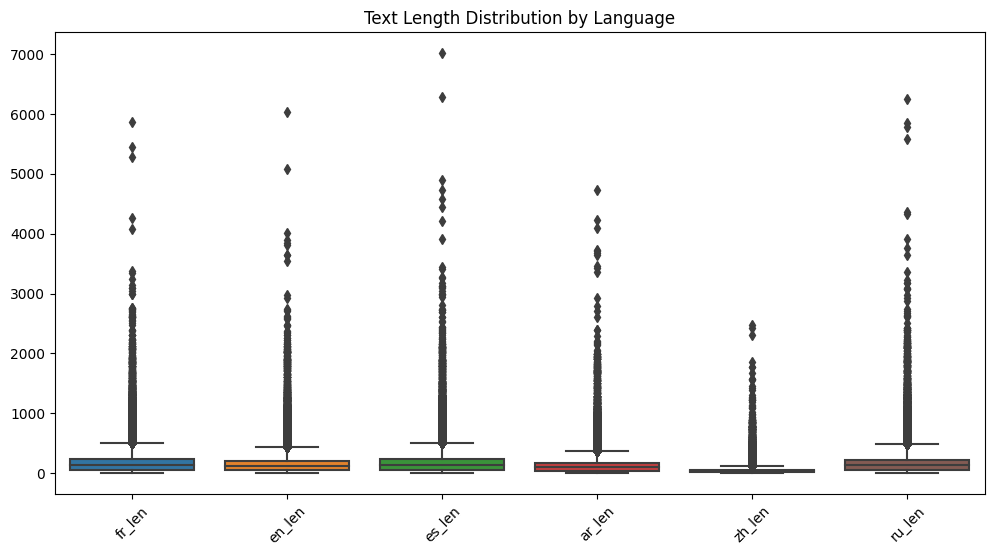


Text Length Statistics:
              fr_len         en_len         es_len         ar_len  \
count  360103.000000  360103.000000  360103.000000  360103.000000   
mean      162.391993     144.434092     164.377189     124.686984   
std       148.728481     130.231928     149.755447     111.658026   
min         1.000000       1.000000       1.000000       1.000000   
25%        50.000000      48.000000      52.000000      44.000000   
50%       136.000000     122.000000     138.000000     105.000000   
75%       231.000000     203.000000     232.000000     174.000000   
max      5872.000000    6028.000000    7014.000000    4738.000000   

              zh_len         ru_len  
count  360103.000000  360103.000000  
mean       44.136242     158.403854  
std        45.513966     145.984002  
min         1.000000       1.000000  
25%        17.000000      49.000000  
50%        35.000000     132.000000  
75%        58.000000     225.000000  
max      2478.000000    6255.000000  


In [11]:
# Basic Dataset Info
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("\nMemory usage:", train_df.memory_usage().sum() / 1024**2, "MB")

# Text Length Analysis
for lang in ['fr', 'en', 'es', 'ar', 'zh', 'ru']:
    train_df[f'{lang}_len'] = train_df[lang].str.len()

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df[[f'{lang}_len' for lang in ['fr', 'en', 'es', 'ar', 'zh', 'ru']]])
plt.title('Text Length Distribution by Language')
plt.xticks(rotation=45)
plt.show()

# Length Statistics
print("\nText Length Statistics:")
print(train_df[[f'{lang}_len' for lang in ['fr', 'en', 'es', 'ar', 'zh', 'ru']]].describe())

In [12]:
def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    return len(set1.intersection(set2)) / len(set1.union(set2))

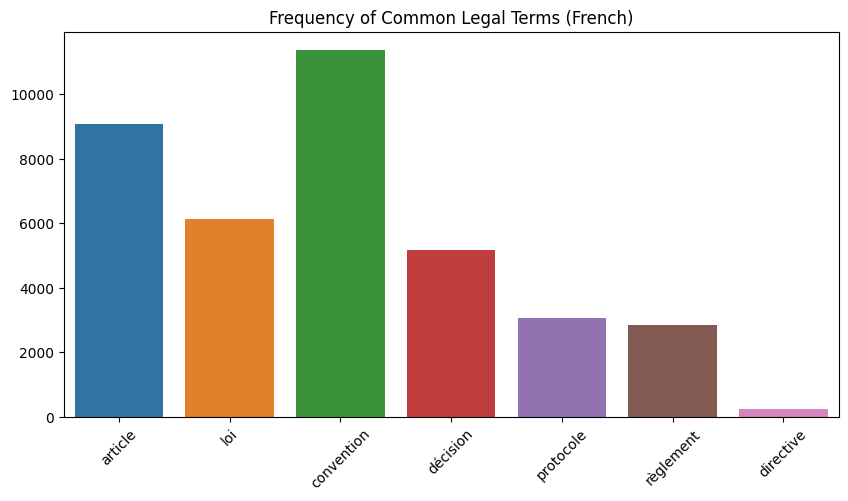

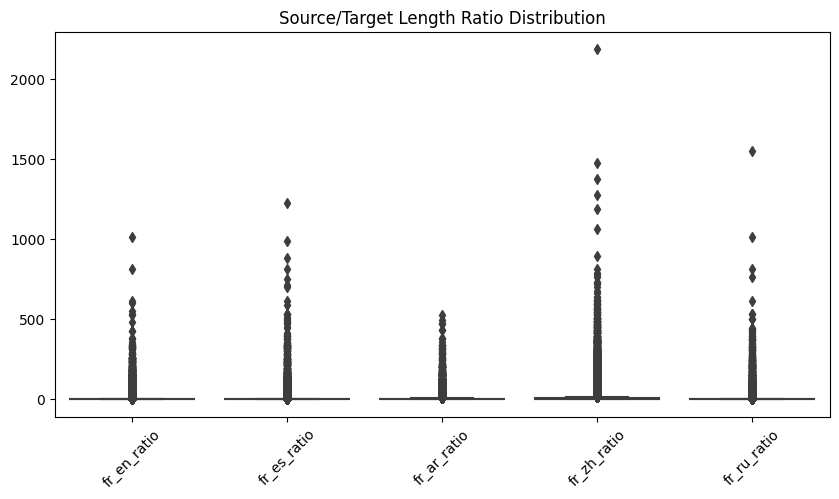

In [13]:
# Common Legal Terms Analysis (French)
def extract_legal_terms(text):
    legal_terms = re.findall(r'\b(loi|article|convention|règlement|directive|protocole|décision)\b', text.lower())
    return legal_terms

legal_terms = train_df['fr'].apply(extract_legal_terms).sum()
term_freq = Counter(legal_terms)

plt.figure(figsize=(10, 5))
sns.barplot(x=list(term_freq.keys()), y=list(term_freq.values()))
plt.title('Frequency of Common Legal Terms (French)')
plt.xticks(rotation=45)
plt.show()

# Language Pair Length Ratio
for lang in ['en', 'es', 'ar', 'zh', 'ru']:
    train_df[f'fr_{lang}_ratio'] = train_df['fr_len'] / train_df[f'{lang}_len']

plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df[[f'fr_{lang}_ratio' for lang in ['en', 'es', 'ar', 'zh', 'ru']]])
plt.title('Source/Target Length Ratio Distribution')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Missing Values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Sample Translations
print("\nSample Translations:")
sample_idx = np.random.randint(len(train_df))
for lang in ['fr', 'en', 'es', 'ar', 'zh', 'ru']:
    print(f"\n{lang.upper()}: {train_df[lang][sample_idx]}")

# Save key statistics for model configuration
max_length = int(train_df[[f'{lang}_len' for lang in ['fr', 'en', 'es', 'ar', 'zh', 'ru']]].max().max())
print(f"\nSuggested max_length for tokenization: {max_length}")



Missing Values:
Id             0
ar             0
fr             0
es             0
en             0
zh             0
ru             0
fr_len         0
en_len         0
es_len         0
ar_len         0
zh_len         0
ru_len         0
fr_en_ratio    0
fr_es_ratio    0
fr_ar_ratio    0
fr_zh_ratio    0
fr_ru_ratio    0
dtype: int64

Sample Translations:

FR: Chapitre VIII

EN: (b) The United Nations Appeals Tribunal shall, under conditions prescribed in its statute and rules, exercise appellate jurisdiction over an appeal of a judgment rendered by the United Nations Dispute Tribunal submitted by either party.

ES: a) El Secretario General/la Secretaria General podrá imponer medidas disciplinarias a los funcionarios que hayan cometido una falta de conducta;

AR: يجوز للموظفين أن يستقيلوا من الخدمة بعد أن يقدموا إلى الأمين العام الإشعار المطلوب بموجب أحكام تعيينهم.

ZH: (d) 对于按照工作人员条例(a)款第(六)项的规定解雇的工作人员，如情况确有必要，并经秘书长认为正当时，可增加解雇补偿金，但不得超过按照《工作人员条例》原应发给的数额再加50%；

RU: Положение 12.3

Sugge

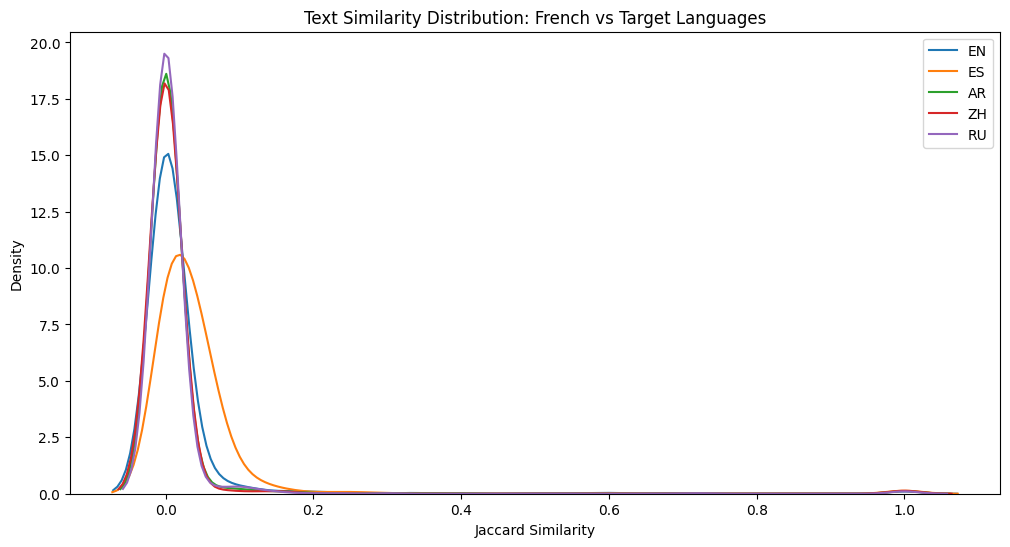


Average Similarities with French:
EN: 0.018
ES: 0.040
AR: 0.010
ZH: 0.009
RU: 0.010


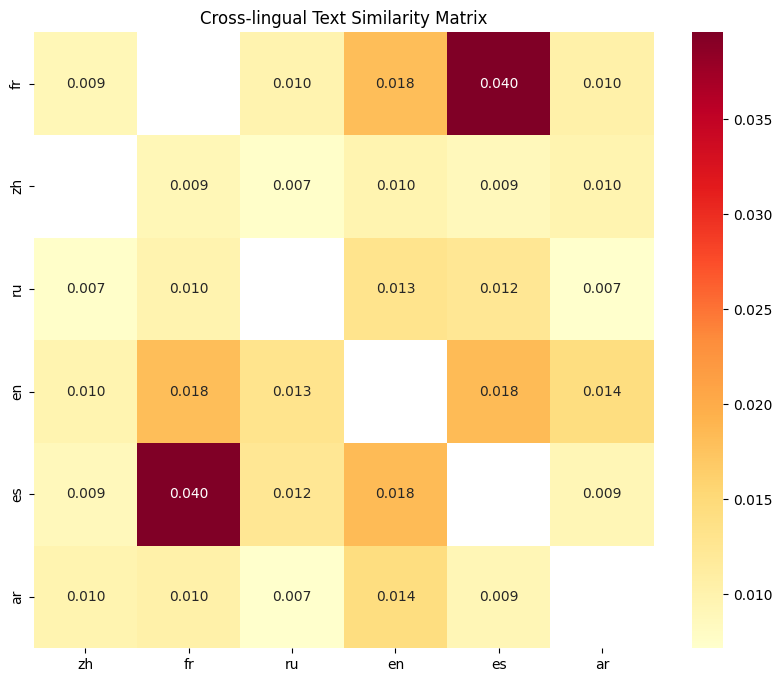

In [18]:
# Language similarity analysis for all pairs
def get_similarity_stats(df, sample_size=1000):
    similarities = {}
    sample_size = min(sample_size, len(df))
    
    for target_lang in ['en', 'es', 'ar', 'zh', 'ru']:
        lang_similarities = []
        for idx in range(sample_size):
            sim = jaccard_similarity(df['fr'].iloc[idx], df[target_lang].iloc[idx])
            lang_similarities.append(sim)
        similarities[target_lang] = lang_similarities
    
    return similarities

# Calculate similarities
similarities = get_similarity_stats(train_df)

# Plot distributions
plt.figure(figsize=(12, 6))
for lang, sims in similarities.items():
    sns.kdeplot(sims, label=lang.upper())
plt.title('Text Similarity Distribution: French vs Target Languages')
plt.xlabel('Jaccard Similarity')
plt.ylabel('Density')
plt.legend()
plt.show()

# Print average similarities
print("\nAverage Similarities with French:")
for lang, sims in similarities.items():
    print(f"{lang.upper()}: {np.mean(sims):.3f}")

# Correlation matrix between all languages
similarity_matrix = pd.DataFrame()
languages = ['fr', 'en', 'es', 'ar', 'zh', 'ru']
for lang1 in languages:
    for lang2 in languages:
        if lang1 < lang2:  # Avoid duplicate calculations
            similarities = []
            for idx in range(min(1000, len(train_df))):
                sim = jaccard_similarity(train_df[lang1].iloc[idx], train_df[lang2].iloc[idx])
                similarities.append(sim)
            similarity_matrix.loc[lang1, lang2] = np.mean(similarities)
            similarity_matrix.loc[lang2, lang1] = similarity_matrix.loc[lang1, lang2]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, cmap='YlOrRd', fmt='.3f')
plt.title('Cross-lingual Text Similarity Matrix')
plt.show()

In [19]:
MODEL_NAME = "facebook/nllb-200-distilled-600M"
MAX_LENGTH = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-4
WARMUP_STEPS = 500

In [ ]:
# Data preprocessing function
def prepare_dataset(df):
    dataset = Dataset.from_pandas(df)
    
    def preprocess(examples):
        inputs = []
        targets = []
        
        for idx in range(len(examples['fr'])):
            fr_text = examples['fr'][idx]
            for lang in ['en', 'es', 'ar', 'zh', 'ru']:
                if lang in examples:
                    inputs.append(fr_text)
                    targets.append(examples[lang][idx])
        
        return {'inputs': inputs, 'targets': targets}
    
    return dataset.map(preprocess, batched=True, remove_columns=dataset.column_names)

In [ ]:
def init_model():
    model = AutoModelForSeq2SeqLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto"
    ).to(device)
    
    # Freeze encoder
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="SEQ_2_SEQ_LM"
    )
    
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    return model

In [ ]:
# Custom learning rate scheduler
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5):
    def lr_lambda(current_step):
        # Warmup phase
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        
        # Cosine decay phase
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

# Training configuration
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    fp16=True,
    save_strategy="steps",
    save_steps=1000,
    logging_dir="./logs",
    logging_steps=100,
    warmup_steps=WARMUP_STEPS,
    optim="adamw_torch",
    gradient_checkpointing=True
)

In [ ]:
# Initialize model and training
model = init_model()
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# Print trainable parameters
model.print_trainable_parameters()

In [ ]:
# Prepare datasets
train_dataset = prepare_dataset(train_df)

In [ ]:
def train(model, train_dataset, tokenizer):
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Calculate total steps
    total_steps = EPOCHS * len(train_dataset) // BATCH_SIZE
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=WARMUP_STEPS,
        num_training_steps=total_steps
    )
    scaler = GradScaler()
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for idx, batch in enumerate(train_dataset):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            with autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
            
            scaler.scale(loss).backward()
            
            if (idx + 1) % 4 == 0:
                scaler.step(optimizer)
                scheduler.step()  # Update learning rate
                scaler.update()
                optimizer.zero_grad()
                
            if idx % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {idx}, Loss: {loss.item():.4f}, LR: {scheduler.get_last_lr()[0]:.2e}")


In [ ]:
try:
    model = init_model()
    train(model, train_dataset, tokenizer)
except Exception as e:
    print(f"Error occurred: {str(e)}")

In [ ]:
def generate_translations(model, text, target_lang_code):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(
            f">>{target_lang_code}<< {text}", 
            return_tensors="pt",
            max_length=MAX_LENGTH,
            truncation=True
        ).to(device)
        
        outputs = model.generate(**inputs, max_length=MAX_LENGTH)
        return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
def generate_submissions(test_df):
    model.eval()
    results = []
    
    for _, row in test_df.iterrows():
        translations = {'fr': row['fr']}
        for lang, code in LANG_CODES.items():
            with torch.no_grad():
                inputs = tokenizer(f">>{code}<< {row['fr']}", return_tensors="pt").to(device)
                outputs = model.generate(**inputs, max_length=MAX_LENGTH)
                translations[lang] = tokenizer.decode(outputs[0], skip_special_tokens=True)
                torch.cuda.empty_cache()
        results.append(translations)
        
    return pd.DataFrame(results)

In [ ]:
# Save submission
submissions_df = generate_submissions(test_df)
submissions_df.to_csv('submission.csv', sep='|', index=False)